In [2]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

2024-12-17 16:54:02.170601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Path to Cityscapes dataset
CITYSCAPES_DIR = "../data"
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest/leftImg8bit/train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest/gtFine/train")
# Limit the number of images to process
# Limit the number of images and pixels
LIMIT_IMAGES = 2975  # Number of images to sample
MAX_PIXELS = 1000000  # Max number of pixels to process
LABEL_ID = 7 # road

In [4]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [5]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [6]:
def plot_random_road_and_nonroad_pixels(image_path, label_path, sampled_road_indices, sampled_non_road_indices):
    """
    Plot all sampled road and non-road pixels on the first image.
    
    Parameters:
        image_path (str): Path to the RGB image.
        label_path (str): Path to the label image.
        sampled_road_indices (list): Indices of sampled road pixels.
        sampled_non_road_indices (list): Indices of sampled non-road pixels.
    """
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Get the image dimensions
    height, width, _ = image.shape

    # Convert linear indices to row, col coordinates
    road_coords = [divmod(idx, width) for idx in sampled_road_indices]
    non_road_coords = [divmod(idx, width) for idx in sampled_non_road_indices]
    
    # Plot the image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot road pixels as red X
    if road_coords:
        road_rows, road_cols = zip(*road_coords)
        plt.scatter(road_cols, road_rows, color='red', s=50, marker='x', label='Road Pixels')
    
    # Plot non-road pixels as blue X
    if non_road_coords:
        non_road_rows, non_road_cols = zip(*non_road_coords)
        plt.scatter(non_road_cols, non_road_rows, color='blue', s=50, marker='x', label='Non-Road Pixels')
    
    plt.title('Sampled Pixels on First Image')
    plt.legend()
    plt.show()

In [7]:
def preprocess_data(image_label_pairs, max_pixels=10000, label_Id=7):
    """Extract pixel RGB values and labels for training, and plot the first image's sampled pixels."""
    X = []  # Pixel RGB values
    y = []  # Binary labels (road or not road)
    total_pixels = 0
    pixels_per_image = max_pixels // len(image_label_pairs) // 2

    for idx, (image_path, label_path) in enumerate(tqdm.tqdm(image_label_pairs)):
        # Load RGB image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Load label image
        label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
        
        # Flatten image and labels into 1D arrays
        image_pixels = image.reshape(-1, 3)  # RGB values
        label_pixels = label_img.flatten()  # Label IDs
        
        # Filter for road (TrainId = 7) and not-road
        road_mask = (label_pixels == label_Id)
        not_road_mask = ~road_mask
        
        # Create subsets for road and not-road pixels
        road_pixels = image_pixels[road_mask]
        not_road_pixels = image_pixels[not_road_mask]

        road_indices = np.where(road_mask)[0]
        not_road_indices = np.where(not_road_mask)[0]

        # Randomly sample pixels from each image
        sampled_road_indices = np.random.choice(road_indices, min(pixels_per_image, len(road_pixels)), replace=False)
        sampled_non_road_indices = np.random.choice(not_road_indices, min(pixels_per_image, len(not_road_pixels)), replace=False)

        sampled_road_pixels = image_pixels[sampled_road_indices]
        sampled_not_road_pixels = image_pixels[sampled_non_road_indices]
        
        # Append the samples to the data
        X.extend(sampled_road_pixels)
        y.extend([1] * len(sampled_road_pixels))  # Road pixels labeled as 1
        
        X.extend(sampled_not_road_pixels)
        y.extend([0] * len(sampled_not_road_pixels))  # Not-road pixels labeled as 0
        
        total_pixels += len(sampled_road_pixels) + len(sampled_not_road_pixels)
        
        # Save data for the first image
        if idx == 0:
            plot_random_road_and_nonroad_pixels(image_path, label_path, sampled_road_indices, sampled_non_road_indices)
        
        # Stop if we reach the max pixel limit
        if total_pixels >= max_pixels:
            break

    return np.array(X), np.array(y)

  0%|          | 0/2975 [00:00<?, ?it/s]

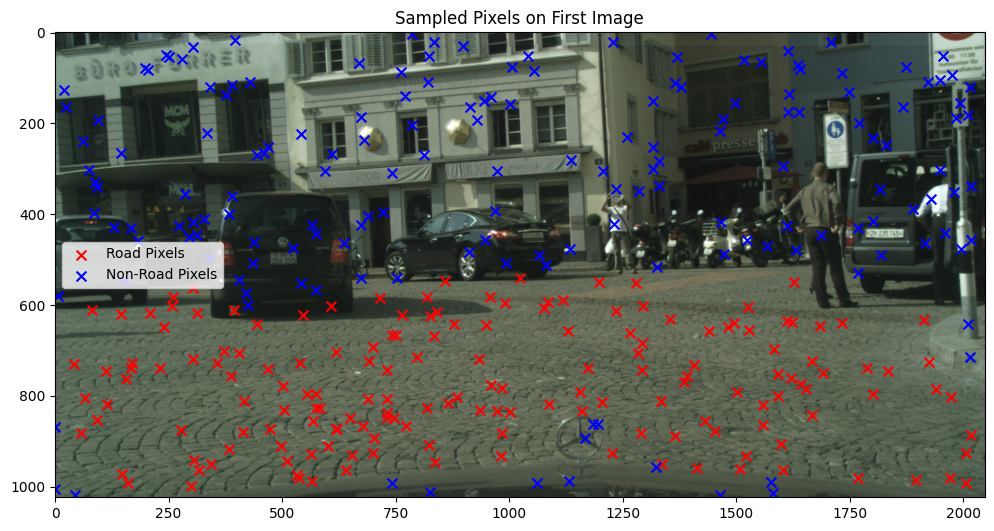

100%|██████████| 2975/2975 [12:06<00:00,  4.09it/s]


In [8]:
# Get image-label pairs
image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)

# Preprocess data with pixel limit
X, y = preprocess_data(image_label_pairs, max_pixels=MAX_PIXELS)


In [9]:
print(f"Processed {len(X)} pixels")
print(f"Number of road pixels: {np.sum(y)}")
print(f"Number of not road pixels: {len(y) - np.sum(y)}")

Processed 992712 pixels
Number of road pixels: 492912
Number of not road pixels: 499800


In [10]:
# Normalize RGB values
X = X / 255.0  # Scale RGB to [0, 1]

In [11]:
# Model training pipeline
import tensorflow as tf
from tensorflow.keras import layers, models

In [12]:
# Build pixel classifier
def build_pixel_classifier():
    model = models.Sequential([
        layers.Input(shape=(3,)),  # RGB input
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output: road (1) or not road (0)
    ])
    return model

In [13]:
# Build and compile the model
model = build_pixel_classifier()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Train the model
#model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
3103/3103 [==============================] - 15s 4ms/step - loss: 0.5465 - accuracy: 0.7240 - val_loss: 0.5149 - val_accuracy: 0.7485
Epoch 2/10
3103/3103 [==============================] - 16s 5ms/step - loss: 0.5114 - accuracy: 0.7529 - val_loss: 0.5084 - val_accuracy: 0.7560
Epoch 3/10
3103/3103 [==============================] - 16s 5ms/step - loss: 0.5050 - accuracy: 0.7568 - val_loss: 0.5064 - val_accuracy: 0.7531
Epoch 4/10
3103/3103 [==============================] - 16s 5ms/step - loss: 0.5014 - accuracy: 0.7584 - val_loss: 0.5003 - val_accuracy: 0.7589
Epoch 5/10
3103/3103 [==============================] - 16s 5ms/step - loss: 0.4995 - accuracy: 0.7596 - val_loss: 0.4971 - val_accuracy: 0.7602
Epoch 6/10
3103/3103 [==============================] - 16s 5ms/step - loss: 0.4970 - accuracy: 0.7616 - val_loss: 0.4960 - val_accuracy: 0.7620
Epoch 7/10
3103/3103 [==============================] - 17s 5ms/step - loss: 0.4958 - accuracy: 0.7626 - val_loss: 0.4939 - val_ac

In [15]:
model = models.load_model('road_dumb_pixel_classifier.h5')

/Users/tommaso/D3A/Computer vision/CV_proj/CV_Proj_Venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


6205/6205 ━━━━━━━━━━━━━━━━━━━━ 4s 660us/step
              precision    recall  f1-score   support

           0       0.83      0.68      0.75    100017
           1       0.72      0.86      0.79     98526

    accuracy                           0.77    198543
   macro avg       0.78      0.77      0.77    198543
weighted avg       0.78      0.77      0.77    198543



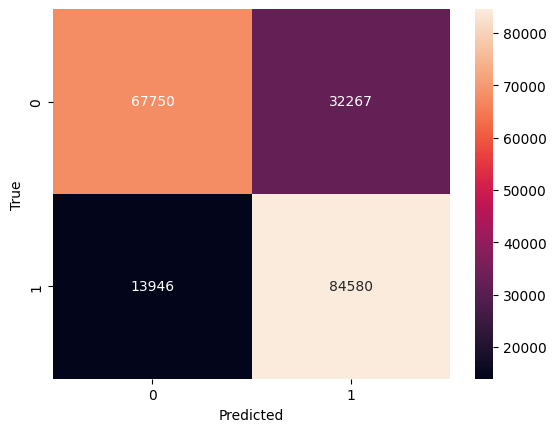

In [16]:
#plot the confusion matrix of the model so i can see f1, accuracy, ecc...
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
#print classification report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


6205/6205 ━━━━━━━━━━━━━━━━━━━━ 4s 624us/step


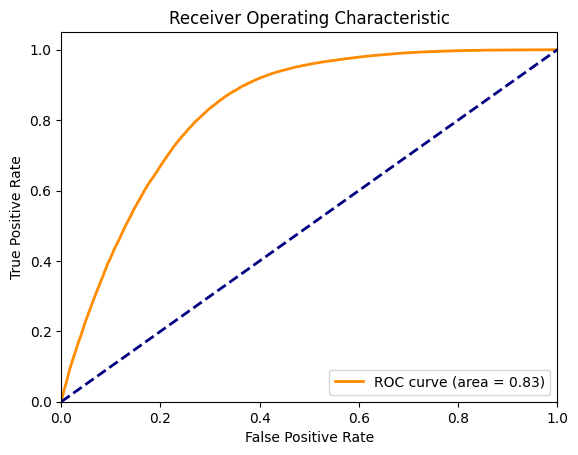

In [17]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_val)

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# save the model
#model.save("road_dumb_pixel_classifier.h5")

65536/65536 [==============================] - 63s 963us/step


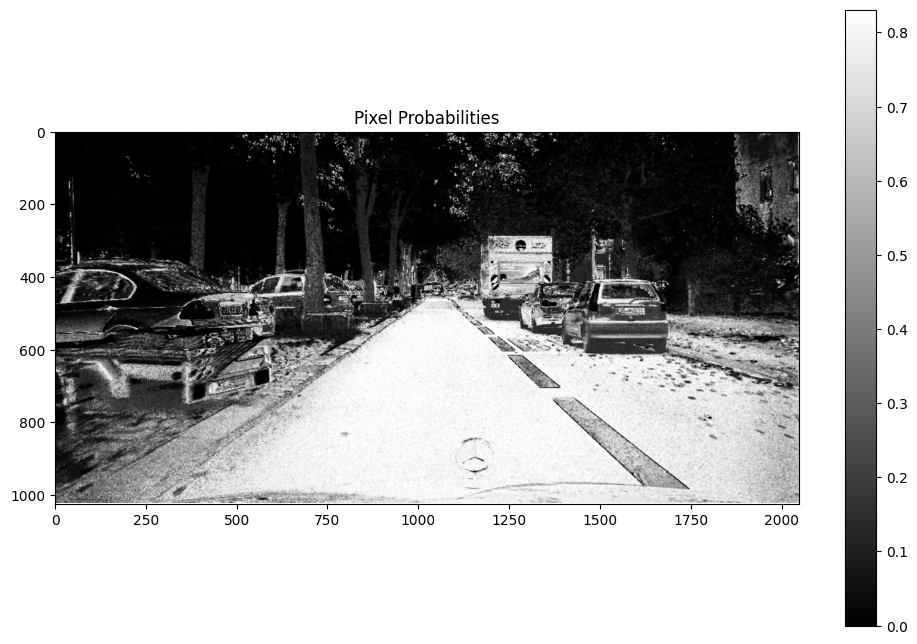

In [ ]:
# i want to take another image and classify all the point in the image with my classifier, then I want to plot for each pixel the probability of being a road pixel so that it is a grayscale image from 0 to 1
def classify_image(image_path, model):
    """Classify all pixels in an image using the model."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    height, width, _ = image.shape
    image_pixels = image.reshape(-1, 3) / 255.0  # Normalize RGB
    
    # Predict pixel labels
    pixel_labels = model.predict(image_pixels).reshape(height, width)
    return pixel_labels

def plot_pixel_probabilities(image_path, pixel_labels):
    """Plot pixel probabilities as a grayscale image."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    plt.figure(figsize=(12, 8))
    plt.imshow(pixel_labels, cmap='gray')
    plt.colorbar()
    plt.title('Pixel Probabilities')
    plt.show()

# Load the model
model = tf.keras.models.load_model("road_dumb_pixel_classifier.h5")

# Classify an image
image_path = r"..\data\leftImg8bit_trainvaltest\leftImg8bit\test\berlin\berlin_000529_000019_leftImg8bit.png"
#pixel_labels = classify_image(image_path, model)
#plot_pixel_probabilities(image_path, pixel_labels)


In [19]:
# def predict_on_image(model, image_path, target_size=256):
#     # Load the image
#     image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     if image is None:
#         raise ValueError(f"Cannot read image from path: {image_path}")
    
#     h, w = image.shape[:2]

#     # Calculate new height based on aspect ratio
#     target_height = int((target_size / w) * h)

#     # Resize the image
#     image_resized = cv2.resize(image, (target_size, target_height))
#     prediction = model.predict(np.expand_dims(image_resized, axis=0))
#     return image_resized, prediction

# # Define the path to the 'personal_images' folder
# image_folder = os.path.join('..','data', 'personal_images')

# # Iterate over all images in the 'personal_images' folder
# for image_name in os.listdir(image_folder):
#     # Check if the file is an image (you can add more formats if needed)
#     if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
#         image_path = os.path.join(image_folder, image_name)
#         print(f"Processing image: {image_path}")
        
#         # Get the image and prediction
#         image_resized, prediction = predict_on_image(model, image_path, target_size=256)
        
#         # Plot the image and prediction
#         plt.figure(figsize=(10, 5))
        
#         plt.subplot(1, 2, 1)
#         plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
#         plt.axis('off')
#         plt.title(f"Image: {image_name}")
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(prediction.squeeze(), cmap='gray')  # Assuming the prediction is a single-channel image
#         plt.axis('off')
#         plt.title("Prediction")
        
#         plt.tight_layout()
#         plt.show()
